In [168]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [169]:
def model_building(X_train, y_train, X_test, y_test, look_back,scaler): 
                
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
                
    model = Sequential()
    #model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(4,input_shape=(1,look_back)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X_train, y_train, epochs=5, verbose=0)
    
    
    #------ Prediction ------ #
    
    train_predict = model.predict(X_train)
    train_predict = scaler.inverse_transform(train_predict)
    
    test_predict = model.predict(X_test)
    test_predict = scaler.inverse_transform(test_predict)
    
    y_train = scaler.inverse_transform(y_train.reshape(-1,1))
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    
    train_score = np.sqrt(mean_squared_error(y_train, train_predict))
    print('Train Score: %.2f RMSE' % (train_score))
    test_score = np.sqrt(mean_squared_error(y_test, test_predict))
    print('Test Score: %.2f RMSE' % (test_score))
        
    
    
    train_predictPlot = np.zeros((len(train_predict),1))
    train_predictPlot[:, :] = np.nan
    
    # could not broadcast input array from shape (23067,) into shape (23047,1)
    #add 0 * lookback to the end of the array train_predict 
    train_predictPlot = np.append(train_predictPlot, train_predict).reshape(-1,1)
    
    
    train_predictPlot[look_back:len(train_predict)+look_back] = train_predict.reshape(-1,1)
    
    
    test_predictPlot = np.zeros((len(test_predict),1))
    test_predictPlot[:, :] = np.nan
    test_predictPlot = np.append(test_predictPlot, test_predict).reshape(-1,1)
    
    test_predictPlot[look_back:len(test_predict)+look_back] = test_predict.reshape(-1,1)
    
    return train_predictPlot, test_predictPlot
    
      
    # define model
    """    model = Sequential()
        model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_input, n_features)))
        model.add(LSTM(200, activation='relu'))
        model.add(Dense(100, activation='relu'))
        model.add(Dense(n_output))
        model.compile(optimizer='adam', loss='mse')
        # fit model
        model.fit(train, epochs=50, verbose=0)
        # predict
        pred_list = []
        batch = train[-n_input:].reshape((1, n_input, n_features))
        for i in range(n_input):
            pred_list.append(model.predict(batch)[0])
            batch = np.append(batch[:, 1:, :], [[pred_list[i]]], axis=1)
        # inverse scaling
        pred_list = scaler.inverse_transform(pred_list)
        # prediction
        df_predict = pd.DataFrame(pred_list, columns=['Prediction'])
        df_test = pd.concat([df, df_predict], axis=1)
        # plot
        df_test.plot(figsize=(20, 5))
        return df_test"""

In [170]:
from matplotlib import pyplot as plt
from bokeh.io import output_notebook
output_notebook()

def plotting(trainPredictPlot, testPredictPlot,record_to_plot,true_data):
    #plt.plot(true_data, label='True data')
    plt.plot(trainPredictPlot, label='Training set prediction')
    plt.plot(testPredictPlot, label='Test set prediction')
    plt.legend()

    plt.show()
    

Loading BokehJS ...

In [171]:
def stacked_lstm(financial_data,record_to_plot:int=2000):
    financial_data = financial_data.reset_index()
    financial_data = financial_data[:record_to_plot]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(np.array(financial_data['Close']).reshape(-1, 1))
    
    # Splitting dataset into train and test split
    # As we are using time series data, we need to split the data in train and test on the basis of time not just take the first 80% data as train and remaining as test
    
    """train =[]
    test = []
    for i in range(financial_data.shape[0]):
        # add every 5th record to test data and remaining to train data so that we have continuous data in test data
        if i%5 == 0:
            test.append(scaled_data[i])
        else:
            train.append(scaled_data[i])"""
    train = scaled_data[:int(0.8*len(scaled_data))]
    test = scaled_data[int(0.8*len(scaled_data)):]
    
    
    # convert train and test data to numpy array
    train = np.array(train)
    test = np.array(test)
    
    def create_dataset(dataset, look_back:int):
        X, Y = [], []
        for i in range(len(dataset)-look_back-1):
            a = dataset[i:(i+look_back)]
            X.append(a)
            Y.append(dataset[i + look_back])
        return np.array(X), np.array(Y)
    
    
    lookback = 20
    X_train, y_train = create_dataset(train, lookback)
    X_test, y_test = create_dataset(test, lookback)
    
    """   X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])"""
    
    #y_train = y_train.reshape(-1,1)
    #y_test = y_test.reshape(-1,1)
    
    trainPredictPlot, testPredictPlot = model_building(X_train,y_train,X_test,y_test,lookback,scaler)

    true_data = financial_data['Close']
    plotting(trainPredictPlot, testPredictPlot,record_to_plot,true_data)
    


In [172]:
financial_data = pd.read_csv(
    "..\data\EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")

# delete dollar sign
try:
    # Clean up dollar signs and convert columns to numeric values
    financial_data["Close/Last"] = financial_data["Close/Last"].str.replace(
        "$", "").astype(float)
    financial_data["Open"] = financial_data["Open"].str.replace(
        "$", "").astype(float)
    financial_data["High"] = financial_data["High"].str.replace(
        "$", "").astype(float)
    financial_data["Low"] = financial_data["Low"].str.replace(
        "$", "").astype(float)
except Exception:
    pass

# rename the headers
try:
    financial_data.rename(columns={"Close/Last": "Close"}, inplace=True)
except Exception:
    pass


In [173]:
financial_data.rename(columns={"high": "High"}, inplace=True)
financial_data.rename(columns={"low": "Low"}, inplace=True)
financial_data.rename(columns={"open": "Open"}, inplace=True)
financial_data.rename(columns={"volume": "Volume"}, inplace=True)
financial_data.rename(columns={"close": "Close"}, inplace=True)


financial_data = financial_data.reset_index(drop=True)

12/12 [==============================] - 0s 3ms/step
Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


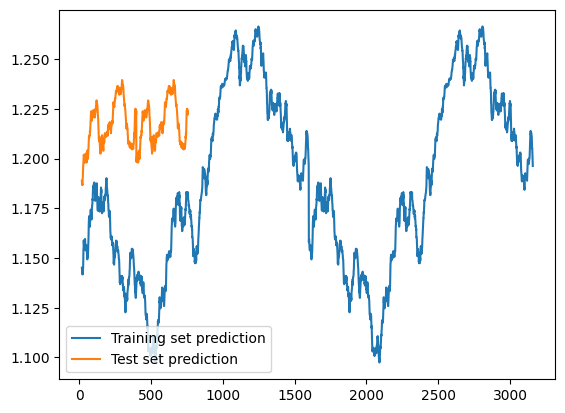

In [174]:
stacked_lstm(financial_data,record_to_plot=2000)
